In [25]:
!pip install resampy
!pip install matplotlib

     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     ---------------- -------------------- 71.7/162.8 kB 435.7 kB/s eta 0:00:01
     -------------------- ---------------- 92.2/162.8 kB 476.3 kB/s eta 0:00:01
     --------------------------------- -- 153.6/162.8 kB 573.4 kB/s eta 0:00:01
     ------------------------------------ 162.8/162.8 kB 610.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.7 MB 1.5 MB/s eta 0:00:05
    --------------------------------------- 0.2/7.7 MB 1.6 MB/s eta 0:00:05
   - -------------------------------------- 0.2/7.7 MB 1.6 MB/s eta 0:00:05
   - -------------------------------------- 0.2/7.7 MB 1.6 MB/s eta 0:00:05
   - -------

In [26]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


In [4]:
def feature_extractor(file):
    audio, sample_rate = librosa.load(file, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [5]:
# Load metadata
audio_dataset_path="50_speakers_audio_data"
metadata=pd.read_csv("audio_files.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,class,classID
0,Speaker26_000.flac,NaN,NaN,NaN,NaN,1,Speaker26,0
1,Speaker26_001.flac,NaN,NaN,NaN,NaN,1,Speaker26,0
2,Speaker26_002.flac,NaN,NaN,NaN,NaN,1,Speaker26,0
3,Speaker26_003.flac,NaN,NaN,NaN,NaN,1,Speaker26,0
4,Speaker26_004.flac,NaN,NaN,NaN,NaN,1,Speaker26,0


In [6]:
# Extract features
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), "fold" + str(row["fold"]) + "/", str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = feature_extractor(file_name)
    extracted_features.append([data, final_class_labels])

2511it [12:07,  3.45it/s]


In [7]:
extracted_features_df = pd.DataFrame(extracted_features, columns=["features", "class"])
print(extracted_features_df.tail())

                                               features         class
2506  [-439.79703, 138.85938, 24.101765, 30.931599, ...  Speaker_0025
2507  [-437.12616, 135.49054, 14.807958, 31.179174, ...  Speaker_0025
2508  [-433.47272, 131.9671, 17.065224, 34.500507, 1...  Speaker_0025
2509  [-431.39542, 136.403, 18.684359, 34.184193, 19...  Speaker_0025
2510  [-529.8196, 67.4511, 10.1421795, 17.78321, 14....  Speaker_0025


In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(1. / input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(1. / hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, hidden_size3) * np.sqrt(1. / hidden_size2)
        self.b3 = np.zeros((1, hidden_size3))
        self.W4 = np.random.randn(hidden_size3, output_size) * np.sqrt(1. / hidden_size3)
        self.b4 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.relu(self.z3)
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        return self.softmax(self.z4)

    def backward(self, X, y, learning_rate=0.0001):
        self.forward(X)
        delta4 = self.softmax(self.z4) - y
        dW4 = np.dot(self.a3.T, delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)

        delta3 = np.dot(delta4, self.W4.T) * (self.a3 > 0)
        dW3 = np.dot(self.a2.T, delta3)
        
        
        db3 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = np.dot(delta3, self.W3.T) * (self.a2 > 0)
        dW2 = np.dot(self.a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = np.dot(delta2, self.W2.T) * (self.a1 > 0)
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # Gradient clipping
        dW1, dW2, dW3, dW4 = [np.clip(dW, -1, 1) for dW in [dW1, dW2, dW3, dW4]]
        db1, db2, db3, db4 = [np.clip(db, -1, 1) for db in [db1, db2, db3, db4]]

        # Update weights with L2 regularization
        self.W1 -= learning_rate * (dW1 + 0.01 * self.W1)
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * (dW2 + 0.01 * self.W2)
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * (dW3 + 0.01 * self.W3)
        self.b3 -= learning_rate * db3
        self.W4 -= learning_rate * (dW4 + 0.01 * self.W4)
        self.b4 -= learning_rate * db4

    def predict(self, x):
        probabilities = self.forward(x)
        return np.argmax(probabilities, axis=1)

    def compute_loss(self, X, y):
        probabilities = self.forward(X)
        correct_logprobs = -np.log(np.clip(probabilities, 1e-10, 1.0)) * y
        data_loss = np.sum(correct_logprobs)
        return 1.0 / len(X) * data_loss

    def compute_accuracy(self, X, y):
        probabilities = self.forward(X)
        predictions = np.argmax(probabilities, axis=1)
        labels = np.argmax(y, axis=1)
        accuracy = np.mean(predictions == labels)
        return accuracy

In [9]:
# Prepare data for training
x = np.array(extracted_features_df["features"].tolist())
y = np.array(extracted_features_df["class"].tolist())

# Normalize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

labelencoder = preprocessing.LabelEncoder()
y_encoded = labelencoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [10]:
# Veri setlerini %70 eğitim, %30 test olacak şekilde ayırma
X_train, X_val, y_train, y_val = train_test_split(x_scaled, y_categorical, test_size=0.3, random_state=42)

In [30]:
def train(X_train, y_train, X_val, y_val, model, epochs, learning_rate=0.0001, early_stopping=True, patience=15):
    best_loss = float('inf')
    no_improve_epoch = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.backward(X_train, y_train, learning_rate)
        train_loss = model.compute_loss(X_train, y_train)
        val_loss = model.compute_loss(X_val, y_val)
        train_acc = model.compute_accuracy(X_train, y_train)
        val_acc = model.compute_accuracy(X_val, y_val)

        # Storing metrics in the history dictionary
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {train_loss:} - Train accuracy: {train_acc:} - Val loss: {val_loss:} - Val accuracy: {val_acc:}")

        if early_stopping:
            if val_loss < best_loss:
                best_loss = val_loss
                no_improve_epoch = 0
            else:
                no_improve_epoch += 1
                if no_improve_epoch >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

    # Plotting the training history
    plt.figure(figsize=(12, 6))

    # Subplot for loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    y_pred = model.predict(X_val)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    return accuracy

In [33]:
# Model setup
input_size = x_scaled.shape[1]
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
output_size = y_categorical.shape[1]
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

# Training parameters
epochs = 200
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1


Epoch 1/200 - Train loss: 3.9948248799583532 - Train accuracy: 0.00149402390438247 - Val loss: 3.994320775830436 - Val accuracy: 0.0019880715705765406
Epoch 2/200 - Train loss: 3.990023428066359 - Train accuracy: 0.00149402390438247 - Val loss: 3.9896112110065265 - Val accuracy: 0.0019880715705765406
Epoch 3/200 - Train loss: 3.985244619783131 - Train accuracy: 0.00149402390438247 - Val loss: 3.984926622986127 - Val accuracy: 0.0019880715705765406
Epoch 4/200 - Train loss: 3.9804806191648687 - Train accuracy: 0.00149402390438247 - Val loss: 3.9802550861817863 - Val accuracy: 0.0019880715705765406
Epoch 5/200 - Train loss: 3.975746337961862 - Train accuracy: 0.00149402390438247 - Val loss: 3.9756266951043786 - Val accuracy: 0.0019880715705765406
Epoch 6/200 - Train loss: 3.9710486159710983 - Train accuracy: 0.00199203187250996 - Val loss: 3.9710277696865712 - Val accuracy: 0.0019880715705765406
Epoch 7/200 - Train loss: 3.9663794802829724 - Train accuracy: 0.00298804780876494 - Val loss

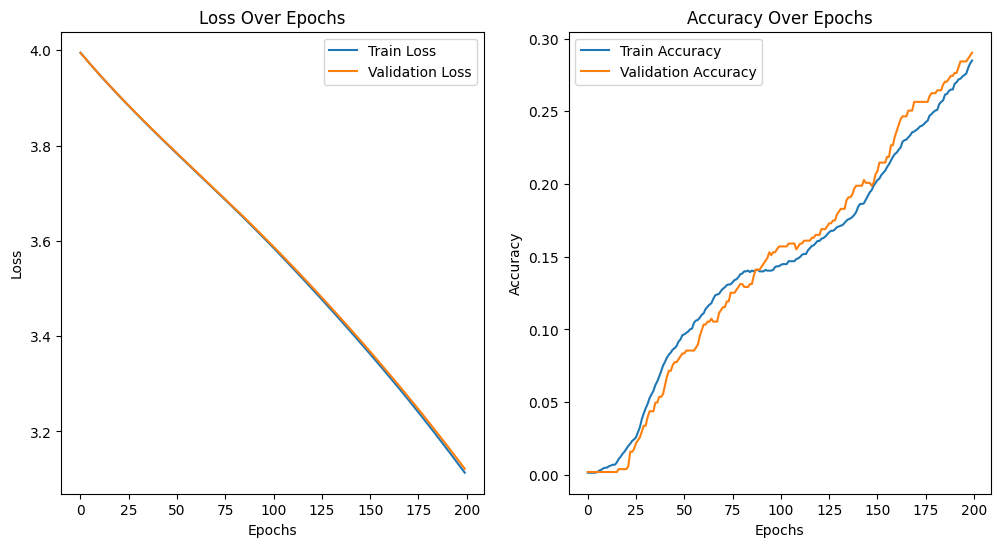

Fold 1 - Accuracy: 0.2903
Epoch 1/200 - Train loss: 3.10947833198003 - Train accuracy: 0.2882030861124938 - Val loss: 3.109684782929143 - Val accuracy: 0.2868525896414343
Epoch 2/200 - Train loss: 3.1040025321355706 - Train accuracy: 0.2887008461921354 - Val loss: 3.104441962314807 - Val accuracy: 0.2868525896414343
Epoch 3/200 - Train loss: 3.0985238308395244 - Train accuracy: 0.29019412643106024 - Val loss: 3.0991791788762257 - Val accuracy: 0.2868525896414343
Epoch 4/200 - Train loss: 3.0930437705705476 - Train accuracy: 0.2931806869089099 - Val loss: 3.093918642123902 - Val accuracy: 0.28884462151394424
Epoch 5/200 - Train loss: 3.087556643234184 - Train accuracy: 0.2936784469885515 - Val loss: 3.088654510383415 - Val accuracy: 0.2908366533864542
Epoch 6/200 - Train loss: 3.082063350041558 - Train accuracy: 0.2946739671478347 - Val loss: 3.0833700719170802 - Val accuracy: 0.29282868525896416
Epoch 7/200 - Train loss: 3.0765625075077505 - Train accuracy: 0.2966650074664012 - Val los

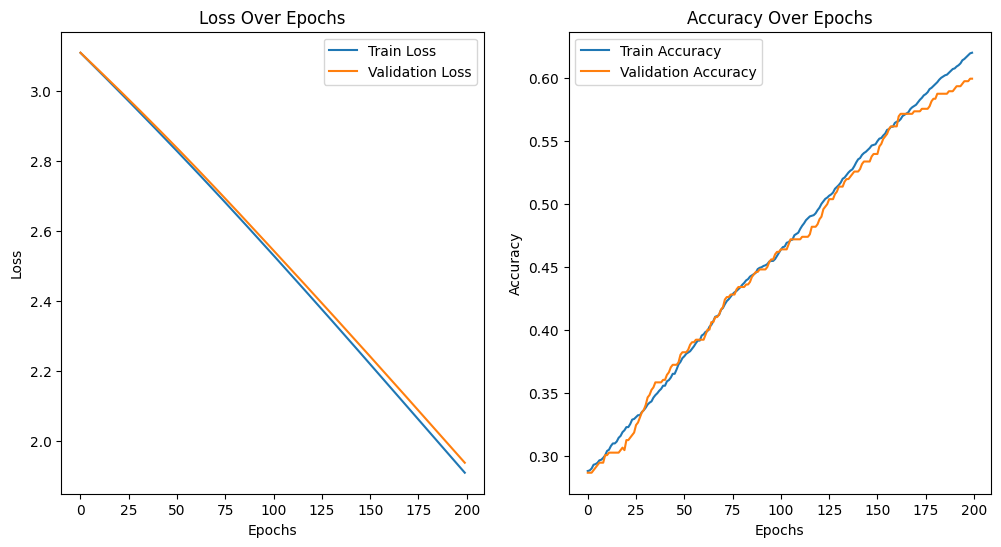

Fold 2 - Accuracy: 0.5996
Epoch 1/200 - Train loss: 1.907860897445805 - Train accuracy: 0.6177202588352414 - Val loss: 1.913402795160264 - Val accuracy: 0.6155378486055777
Epoch 2/200 - Train loss: 1.9015257499564229 - Train accuracy: 0.6202090592334495 - Val loss: 1.9072771451015225 - Val accuracy: 0.6155378486055777
Epoch 3/200 - Train loss: 1.895188115839776 - Train accuracy: 0.6217023394723743 - Val loss: 1.9011465114703994 - Val accuracy: 0.6155378486055777
Epoch 4/200 - Train loss: 1.8888528134483942 - Train accuracy: 0.6241911398705824 - Val loss: 1.8950105156550834 - Val accuracy: 0.6175298804780877
Epoch 5/200 - Train loss: 1.8825238146553187 - Train accuracy: 0.627177700348432 - Val loss: 1.888882223586126 - Val accuracy: 0.6195219123505976
Epoch 6/200 - Train loss: 1.8761994732884415 - Train accuracy: 0.6286709805873569 - Val loss: 1.8827527843777268 - Val accuracy: 0.6195219123505976
Epoch 7/200 - Train loss: 1.8698777031300473 - Train accuracy: 0.6296665007466401 - Val los

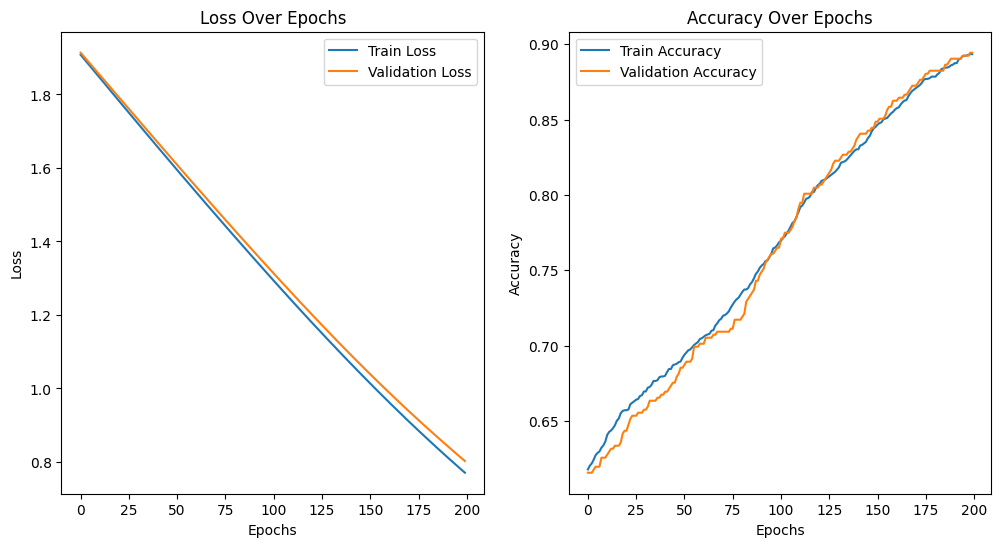

Fold 3 - Accuracy: 0.8944
Epoch 1/200 - Train loss: 0.7733668996396773 - Train accuracy: 0.8954703832752613 - Val loss: 0.7682449307390028 - Val accuracy: 0.8944223107569721
Epoch 2/200 - Train loss: 0.7687371313511121 - Train accuracy: 0.8959681433549029 - Val loss: 0.7640144344690408 - Val accuracy: 0.8944223107569721
Epoch 3/200 - Train loss: 0.7641280457792549 - Train accuracy: 0.8979591836734694 - Val loss: 0.7597993916990785 - Val accuracy: 0.8944223107569721
Epoch 4/200 - Train loss: 0.7595387215416716 - Train accuracy: 0.8999502239920358 - Val loss: 0.7555936396759159 - Val accuracy: 0.8944223107569721
Epoch 5/200 - Train loss: 0.7549667440382652 - Train accuracy: 0.9004479840716775 - Val loss: 0.7513967112803579 - Val accuracy: 0.8944223107569721
Epoch 6/200 - Train loss: 0.7504140024296505 - Train accuracy: 0.9014435042309606 - Val loss: 0.7472055218439364 - Val accuracy: 0.8944223107569721
Epoch 7/200 - Train loss: 0.745879812454604 - Train accuracy: 0.9014435042309606 - Val

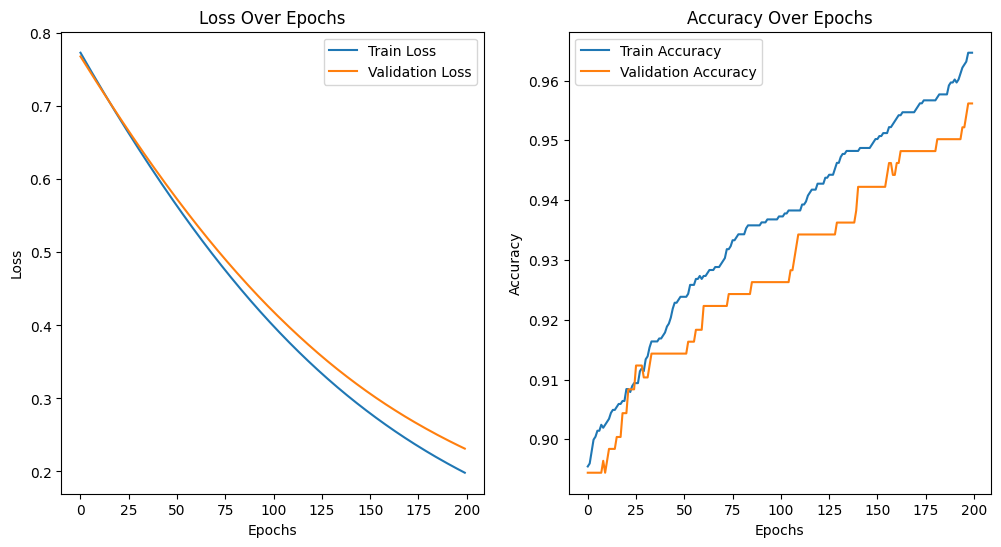

Fold 4 - Accuracy: 0.9562
Epoch 1/200 - Train loss: 0.2097213426686544 - Train accuracy: 0.9621702339472374 - Val loss: 0.17867942108764978 - Val accuracy: 0.9741035856573705
Epoch 2/200 - Train loss: 0.20828058424439863 - Train accuracy: 0.9626679940268791 - Val loss: 0.1776567674401915 - Val accuracy: 0.9741035856573705
Epoch 3/200 - Train loss: 0.20686307664198475 - Train accuracy: 0.9626679940268791 - Val loss: 0.17662797360031077 - Val accuracy: 0.9721115537848606
Epoch 4/200 - Train loss: 0.20546507564327973 - Train accuracy: 0.9626679940268791 - Val loss: 0.1755856134545354 - Val accuracy: 0.9721115537848606
Epoch 5/200 - Train loss: 0.20408307637794076 - Train accuracy: 0.9626679940268791 - Val loss: 0.1745305227435446 - Val accuracy: 0.9721115537848606
Epoch 6/200 - Train loss: 0.2027162743169832 - Train accuracy: 0.9631657541065206 - Val loss: 0.17346764281001636 - Val accuracy: 0.9721115537848606
Epoch 7/200 - Train loss: 0.20136337880698024 - Train accuracy: 0.9636635141861

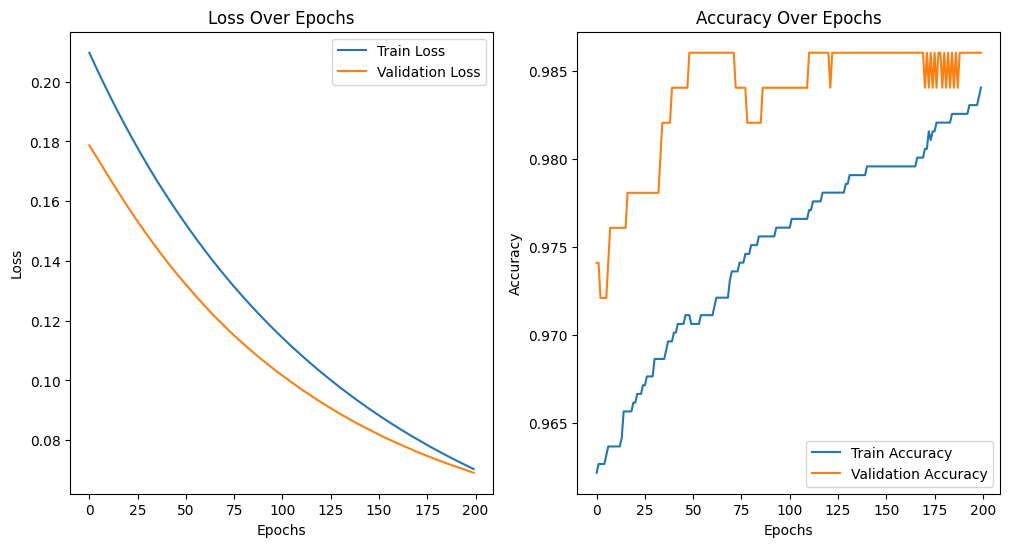

Fold 5 - Accuracy: 0.9861


In [34]:
for train_index, test_index in kfold.split(x_scaled, y_encoded):
    X_train, X_val = x_scaled[train_index], x_scaled[test_index]
    y_train, y_val = y_categorical[train_index], y_categorical[test_index]

    accuracy = train(X_train, y_train, X_val, y_val, model, epochs=epochs)
    print(f'Fold {fold_no} - Accuracy: {accuracy:.4f}')
    fold_no += 1

In [35]:
# Function to predict speaker from an audio file
def predict_speaker(file_path):
    # Extract features using the feature extractor
    features = feature_extractor(file_path)
    # Scale the features using the pre-trained scaler
    scaled_features = scaler.transform([features])
    # Use the pre-trained model to make a prediction
    prediction = model.predict(scaled_features)
    # Decode the predicted class
    speaker = labelencoder.inverse_transform(prediction)[0]
    return speaker

In [37]:
# Example usage
file_path = "50_speakers_audio_data/Speaker0030/Speaker30_026.flac"
speaker = predict_speaker(file_path)
print("Predicted speaker:", speaker)

Predicted speaker: Speaker0030
